# Basic NLP with RNNs

Based on the [Chapter 16 notebook](https://github.com/ageron/handson-ml3/blob/main/16_nlp_with_rnns_and_attention.ipynb) from the book "Hands-On Machine Learning with Scikit-Learn, Keras, and TensorFlow" by Aurélien Géron.

## Download the Shakespeare corpus
Since Shakespeare is in the public domain, there's an entire dataset containing the complete works. Nifty.

In [ ]:
import tensorflow as tf

shakespeare_url = "https://homl.info/shakespeare"  # shortcut URL
filepath = tf.keras.utils.get_file("shakespeare.txt", shakespeare_url)
with open(filepath) as f:
    shakespeare_text = f.read()

# Just like the RNN stuff, create a helper function to map the inputs
# to an RNN-compatible dataset
def to_dataset(sequence, length, shuffle=False, seed=None, batch_size=32):
    ds = tf.data.Dataset.from_tensor_slices(sequence)
    ds = ds.window(length + 1, shift=1, drop_remainder=True)
    ds = ds.flat_map(lambda window_ds: window_ds.batch(length + 1))
    if shuffle:
        ds = ds.shuffle(100_000, seed=seed)
    ds = ds.batch(batch_size)
    return ds.map(lambda window: (window[:, :-1], window[:, 1:])).prefetch(1)

# Define a character tokenization layer
text_vec_layer = tf.keras.layers.TextVectorization(split="character",
                                                   standardize="lower")
text_vec_layer.adapt([shakespeare_text])
encoded = text_vec_layer([shakespeare_text])[0]
encoded -= 2  # drop tokens 0 (pad) and 1 (unknown), which we will not use
n_tokens = text_vec_layer.vocabulary_size() - 2  # number of distinct chars = 39
dataset_size = len(encoded)  # total number of chars = 1,115,394

# use 100 characters to predict the next one
length = 100
tf.random.set_seed(42)
train_set = to_dataset(encoded[:1_000_000], length=length, shuffle=True,
                       seed=42)
valid_set = to_dataset(encoded[1_000_000:1_060_000], length=length)
test_set = to_dataset(encoded[1_060_000:], length=length)

1115394/1115394 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


In [ ]:
from pathlib import Path

# This takes forever to train and Colab stopped giving me GPUs
# shakespeare_model = tf.keras.Sequential([
#     tf.keras.layers.Embedding(input_dim=n_tokens, output_dim=16),
#     tf.keras.layers.GRU(128, return_sequences=True),
#     tf.keras.layers.Dense(n_tokens, activation="softmax")
# ])

# extra code – downloads a pretrained model
url = "https://github.com/ageron/data/raw/main/shakespeare_model.tgz"
path = tf.keras.utils.get_file("shakespeare_model.tgz", url, extract=True)
if "_extracted" in path:
    model_path = Path(path) / "shakespeare_model"
else:
    model_path = Path(path).with_name("shakespeare_model")

# Keras 3 can't just load the old model, we need to do some massaging
shakespeare_model = tf.keras.Sequential([
    tf.keras.layers.TFSMLayer(model_path, call_endpoint="serving_default")
])
shakespeare_model.build()

352865/352865 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


In [ ]:
# Grab the vector of probabilities for the last character of the sequence
y_proba = shakespeare_model.predict(tf.constant(["Whether tis n"]))["sequential"][0, -1,:].squeeze()
y_pred = tf.argmax(y_proba)  # choose the most probable character ID
text_vec_layer.get_vocabulary()[y_pred + 2]

### Generate some fake Shakespearean Text

In [ ]:
def next_char(text, temperature=1):
    y_proba = shakespeare_model.predict(tf.constant([text]), verbose=0)["sequential"][0, -1,:]
    rescaled_logits = tf.expand_dims(tf.math.log(y_proba) / temperature, axis=0)
    # don't just pick the maximum, choose from the distribution
    char_id = tf.random.categorical(rescaled_logits, num_samples=1)[0, 0]
    return text_vec_layer.get_vocabulary()[char_id + 2]

def extend_text(text, n_chars=50, temperature=1):
    for _ in range(n_chars):
        text += next_char(text, temperature)
    return text

In [ ]:
print("Low temperature: more predictable")
print(extend_text("To be or not to be", temperature=0.01))

print("\nTemperature=1: standard softmax")
print(extend_text("To be or not to be", temperature=1))

print("\nHigh Temperature: madness")
print(extend_text("To be or not to be", temperature=10))


Low temperature: more predictable
To be or not to be the duke
as it is a proper strange death,
and the

Temperature=1: standard softmax
To be or not to behold?

second push:
gremio, lord all, a sistermen,

High Temperature: madness
To be or not to be, mrepxe-wlo
dpzido:hievy,h-ehe?;.f ha?m.m;l' m;
;


## Download and prepare the IMDB dataset
The IMDB dataset is kind of a "hello world" of NLP. It contains 50,000 movie reviews, each labeled as positive or negative.

Note: this took forever on my non-GPU laptop, so I'd recommend running this in Colab.

In [ ]:
import tensorflow_datasets as tfds
import tensorflow as tf

raw_train_set, raw_valid_set, raw_test_set = tfds.load(
    name="imdb_reviews",
    split=["train[:90%]", "train[90%:]", "test"],
    as_supervised=True
)
tf.random.set_seed(42)
train_set = raw_train_set.shuffle(5000, seed=42).batch(32).prefetch(1)
valid_set = raw_valid_set.batch(32).prefetch(1)
test_set = raw_test_set.batch(32).prefetch(1)

Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

Generating splits...:   0%|          | 0/3 [00:00<?, ? splits/s]

Generating train examples...: 0 examples [00:00, ? examples/s]

Shuffling /root/tensorflow_datasets/imdb_reviews/plain_text/incomplete.8BPIX1_1.0.0/imdb_reviews-train.tfrecor…

Generating test examples...: 0 examples [00:00, ? examples/s]

Shuffling /root/tensorflow_datasets/imdb_reviews/plain_text/incomplete.8BPIX1_1.0.0/imdb_reviews-test.tfrecord…

Generating unsupervised examples...: 0 examples [00:00, ? examples/s]

Shuffling /root/tensorflow_datasets/imdb_reviews/plain_text/incomplete.8BPIX1_1.0.0/imdb_reviews-unsupervised.…

Dataset imdb_reviews downloaded and prepared to /root/tensorflow_datasets/imdb_reviews/plain_text/1.0.0. Subsequent calls will reuse this data.


In [ ]:
for review, label in raw_train_set.take(4):
    print(review.numpy().decode("utf-8")[:200], "...")
    print("Label:", label.numpy())

This was an absolutely terrible movie. Don't be lured in by Christopher Walken or Michael Ironside. Both are great actors, but this must simply be their worst role in history. Even their great acting  ...
Label: 0
I have been known to fall asleep during films, but this is usually due to a combination of things including, really tired, being warm and comfortable on the sette and having just eaten a lot. However  ...
Label: 0
Mann photographs the Alberta Rocky Mountains in a superb fashion, and Jimmy Stewart and Walter Brennan give enjoyable performances as they always seem to do. <br /><br />But come on Hollywood - a Moun ...
Label: 0
This is the kind of film for a snowy Sunday afternoon when the rest of the world can go ahead with its own business as you descend into a big arm-chair and mellow for a couple of hours. Wonderful perf ...
Label: 1


In [ ]:
vocab_size = 1000
text_vec_layer = tf.keras.layers.TextVectorization(max_tokens=vocab_size)
text_vec_layer.adapt(train_set.map(lambda reviews, labels: reviews))

In [ ]:
for review, label in raw_train_set.take(2):
    print(review)
    print(text_vec_layer(review))

tf.Tensor(b"This was an absolutely terrible movie. Don't be lured in by Christopher Walken or Michael Ironside. Both are great actors, but this must simply be their worst role in history. Even their great acting could not redeem this movie's ridiculous storyline. This movie is an early nineties US propaganda piece. The most pathetic scenes were those when the Columbian rebels were making their cases for revolutions. Maria Conchita Alonso appeared phony, and her pseudo-love affair with Walken was nothing but a pathetic emotional plug in a movie that was devoid of any real meaning. I am disappointed that there are movies like this, ruining actor's like Christopher Walken's good name. I could barely sit through it.", shape=(), dtype=string)
tf.Tensor(
[ 11  14  34 410 383  18  90  28   1   8  33   1   1  41 491   1 192  24
  86 152  19  11 218 315  28  65 241 217   8 487  54  65  86 113  95  22
   1  11  93 644 729  11  18   7  34 396   1 171   1 404   2  88   1 137
  67 144  52   2   1  

**Warning**: training this model will take a few minutes to run and the model will probably not learn anything because we didn't deal with the padding tokens.

In [ ]:
@keras.saving.register_keras_serializable
def custom_standardize(in_tokens):


In [ ]:
embed_size = 128
tf.random.set_seed(42)
model = tf.keras.Sequential([
    text_vec_layer,
    tf.keras.layers.Embedding(vocab_size, embed_size),
    tf.keras.layers.GRU(128),
    tf.keras.layers.Dense(1, activation="sigmoid")
])

model.compile(loss="binary_crossentropy", optimizer="nadam",
              metrics=["accuracy"])
history = model.fit(train_set, validation_data=valid_set, epochs=2)
model.summary()

Epoch 1/2
704/704 ━━━━━━━━━━━━━━━━━━━━ 28s 33ms/step - accuracy: 0.4950 - loss: 0.6939 - val_accuracy: 0.5024 - val_loss: 0.6929
Epoch 2/2
704/704 ━━━━━━━━━━━━━━━━━━━━ 24s 34ms/step - accuracy: 0.5032 - loss: 0.6938 - val_accuracy: 0.5036 - val_loss: 0.6928


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ text_vectorization                   │ (None, None)                │               0 │
│ (TextVectorization)                  │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ embedding (Embedding)                │ (None, None, 128)           │         128,000 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ gru (GRU)                            │ (None, 128)                 │          99,072 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 1)                   │             129 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 681,606 (2.60 MB)

 Trainable params: 227,201 (887.50 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 454,405 (1.73 MB)

That's not a great accuracy, we're basically just randomly guessing! Let's see if we can figure out why.

79/79 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step


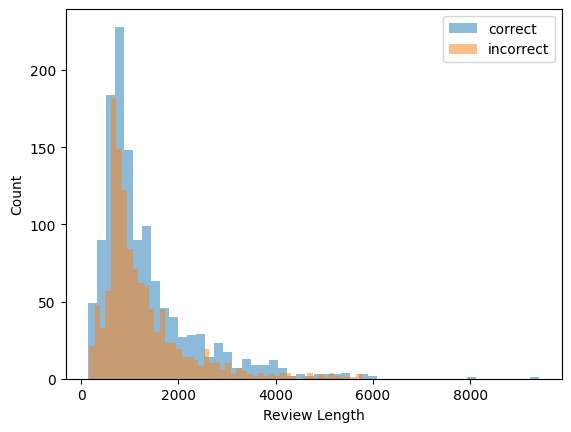

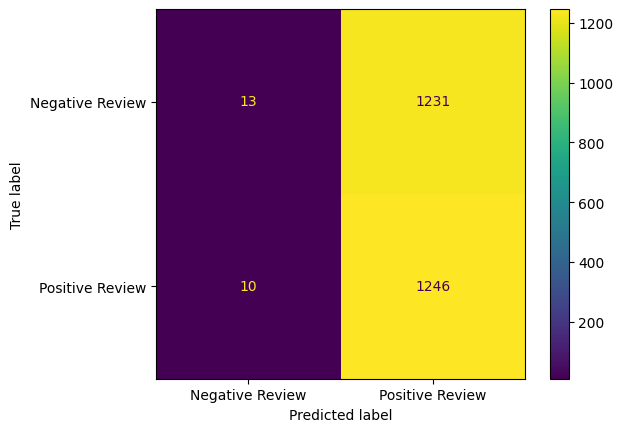

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

def plot_stuff(model):
    predicted = model.predict(valid_set)

    lengths = []
    correct = []
    truth = []
    b = 0
    for batch in valid_set:
        lengths += [len(text.numpy()) for text in batch[0]]
        correct += [(pred > 0.5) == label for pred, label in zip(predicted[b:b+32], batch[1])]
        truth += list(batch[1].numpy())
        b += 32

    lengths = np.array(lengths)
    correct = np.array(correct).squeeze()

    plt.hist(lengths[correct], bins=50, alpha=0.5, label='correct')
    plt.hist(lengths[~correct], bins=50, alpha=0.5, label='incorrect')
    plt.xlabel('Review Length')
    plt.ylabel('Count')
    plt.legend()
    plt.show()

    # show the confusion matrix
    from sklearn.metrics import confusion_matrix
    from sklearn.metrics import ConfusionMatrixDisplay

    bin_pred = (predicted > 0.5).squeeze().astype(int)
    cm = confusion_matrix(truth, bin_pred)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["Negative Review", "Positive Review"])
    disp.plot()

plot_stuff(model)

## Handling variable length inputs
In 2024 Keras supported [Ragged Tensors](https://www.tensorflow.org/guide/ragged_tensor), but now it seems that ragged tensor support has been pulled from Keras. Let's use the masking approach. Basically, we need to tell the model to ignore the trailing end of our inputs where we've padded each review with zeros.

In [ ]:
embed_size = 128
tf.random.set_seed(42)
model = tf.keras.Sequential([
    text_vec_layer,
    # mask_zero=True is the secret sauce
    tf.keras.layers.Embedding(vocab_size, embed_size, mask_zero=True),
    tf.keras.layers.GRU(128),
    tf.keras.layers.Dense(1, activation="sigmoid")
])
model.compile(loss="binary_crossentropy", optimizer="nadam",
              metrics=["accuracy"])
history = model.fit(train_set, validation_data=valid_set, epochs=5)

Epoch 1/5
704/704 ━━━━━━━━━━━━━━━━━━━━ 25s 33ms/step - accuracy: 0.6421 - loss: 0.6239 - val_accuracy: 0.7952 - val_loss: 0.4404
Epoch 2/5
704/704 ━━━━━━━━━━━━━━━━━━━━ 23s 32ms/step - accuracy: 0.8301 - loss: 0.3836 - val_accuracy: 0.8564 - val_loss: 0.3234
Epoch 3/5
704/704 ━━━━━━━━━━━━━━━━━━━━ 41s 32ms/step - accuracy: 0.8719 - loss: 0.3049 - val_accuracy: 0.8712 - val_loss: 0.3091
Epoch 4/5
704/704 ━━━━━━━━━━━━━━━━━━━━ 41s 32ms/step - accuracy: 0.8836 - loss: 0.2776 - val_accuracy: 0.8664 - val_loss: 0.3185
Epoch 5/5
704/704 ━━━━━━━━━━━━━━━━━━━━ 24s 34ms/step - accuracy: 0.8932 - loss: 0.2579 - val_accuracy: 0.8624 - val_loss: 0.3117


79/79 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step


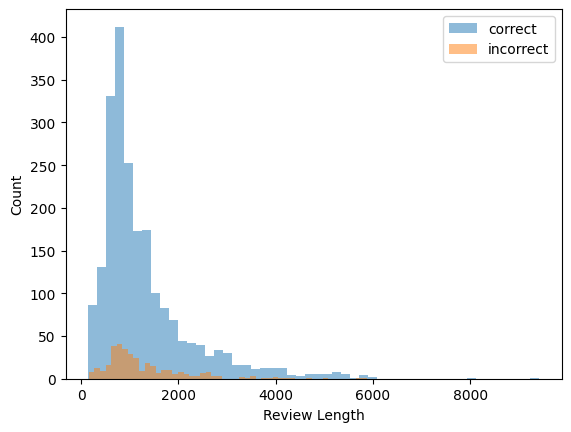

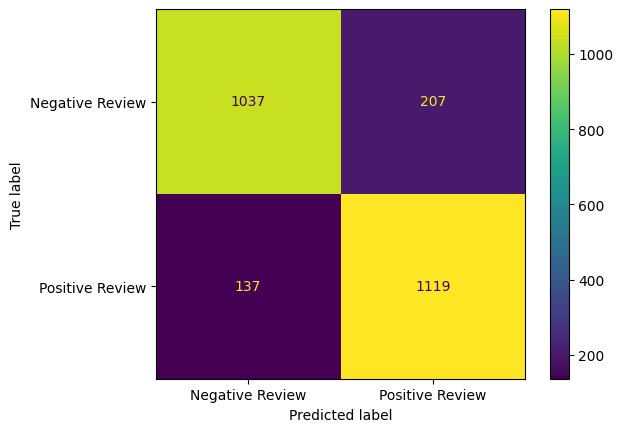

In [ ]:
plot_stuff(model)

In [ ]:
reviews = ("I did not not not love love love this movie",
           "I walked out of the theater early.",
           "This was the best!",
           "I guess it was a movie.",
           "I liked the colour, but it was a movie.",

           "This movie doesn't scrape the bottom of the barrel. ",
           "This movie isn't the bottom of the barrel. ",
           "This movie isn't below the bottom of the barrel. ",
           "This movie doesn't deserve to be mentioned in the same sentence with barrels."
)

# ’ from https://www.rogerebert.com/reviews/freddy-got-fingered-2001#:~:text=This%20movie%20doesn't%20scrape,the%20same%20sentence%20with%20barrels.

predictions = model.predict(tf.constant(reviews))
for rev, pred in zip(reviews, predictions):
    print(rev)
    print(f"Sentiment: {'Positive' if pred > 0.5 else 'Negative'} ({pred[0]:.2f})\n")

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 167ms/step
I did not not not love love love this movie
Sentiment: Negative (0.22)

I walked out of the theater early.
Sentiment: Negative (0.46)

This was the best!
Sentiment: Positive (0.91)

I guess it was a movie.
Sentiment: Negative (0.38)

I liked the colour, but it was a movie.
Sentiment: Positive (0.93)

This movie doesn't scrape the bottom of the barrel. 
Sentiment: Negative (0.12)

This movie isn't the bottom of the barrel. 
Sentiment: Negative (0.40)

This movie isn't below the bottom of the barrel. 
Sentiment: Negative (0.35)

This movie doesn't deserve to be mentioned in the same sentence with barrels.
Sentiment: Negative (0.14)

